### Предсказание средней списочной численности основных производственных рабочих

#### Задача: предоставлены показатели среднесписочной численности основных производственных рабочих (ССЧ ОПР) шести цехов одного завода за 5 лет, исследуем временной ряд, изучимь его свойства, построим модели предсказания и сделаем выводы по результатам.

#### Исходные данные для анализа
Даны файлы с производственными показателями шести цехов:
1. Загрузка план ОПР (без аут.) - показатель плановой загрузки в н/ч за конкретный месяц; 
2. Загрузка факт ОПР (без аут.) - показатель фактической загрузки в н/ч за конкретный месяц;
3. Коэф. выработки - коэффициент выработки (отношение времени отработанного по нормам к табельному времени);
4. Коэф. невыходов - коэффициент невыходов (отношение времени отработанного по табелю к общему фонду рабочего времени);
5. Коэф. сверур. - коэффициент сверхурочки (отношение фонда рабочего времени ко времени работы в вечерние, выходные и праздничные дни);
6. ССЧ - среднесписочная численность основных производственных рабочих в цехе. Целевая функция.

##### Статистические модели прогнозирования.
1. Отложим последние 5 меясцев датасета как тестовую выборку для оценки результатов предсказания.
2. Построем модель скользящего среднего, проанализируем результат. Для построения MA используйте метод rolling, который принимает в качестве параметра размер окна. Используем среднее как функцию для сглаживания.
3. Оценим стационарность временного ряда и примим решение о выборе модели ARMA/ARIMA/SARIMAX. Выберем парамeтры p и q по коррелограммам ACF и PACF. Также построем модель с параметрами, ближайшими к p и q, и сравним коэффициент AIC или подберем наилучшие параметры с помощью pmdarima.
4. Построем модель с наилучшими параметрами и выполним предсказание на 5 месяцев.
5. Отобразим результат графически.
6. Сделаем выводы.

##### Модели прогнозирования гетероскедастичности. Валидация временных рядов.
1. Рассчитаем волатильность для вашего временного ряда.
2. Используем GARCH-модель для предсказания волатильности.
3. Используем линейную регрессию для получения прогноза.
4. Визуализируем полученное предсказание вместе с фактическим значением.
5. Сравним результаты и сделаем выводы какая модель наиболлее применима.

In [1]:
#Импортируем модули и читаем данные
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
from arch import arch_model
from sklearn.linear_model import LinearRegression
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
#Загрузим датасет по 6 цехам
excel_reader = pd.ExcelFile('D:\IDE\Final project\Data/KPW_TBM_2018-2023.xlsx', engine='openpyxl')
df_shop_1 = excel_reader.parse('01_MAS', index_col = 0)
df_shop_2 = excel_reader.parse('02_PaFS', index_col = 0)
df_shop_3 = excel_reader.parse('03_PBS', index_col = 0)
df_shop_4 = excel_reader.parse('04_CES', index_col = 0)
df_shop_5 = excel_reader.parse('05_MSS', index_col = 0)
df_shop_6 = excel_reader.parse('06_HESS', index_col = 0)
df_shop_1.head()

,Загрузка план ОПР (без аут.),Загрузка факт ОПР (без аут.),Коэф. выработки,Коэф. невыходов,Коэф. сверур.,ССЧ
Дата,,,,,,
2018-01-01,13561.698936,11273.895,0.802260,0.875216,1.104588,98.06
2018-02-01,15766.762325,11154.702,0.772623,0.827229,1.044218,105.54
2018-03-01,15848.039089,11113.643,0.827439,0.787282,1.067809,98.84
2018-04-01,19181.353944,14874.078,0.936177,0.813980,1.192620,99.44
2018-05-01,20291.202345,12942.787,0.797815,0.834190,1.231160,103.00


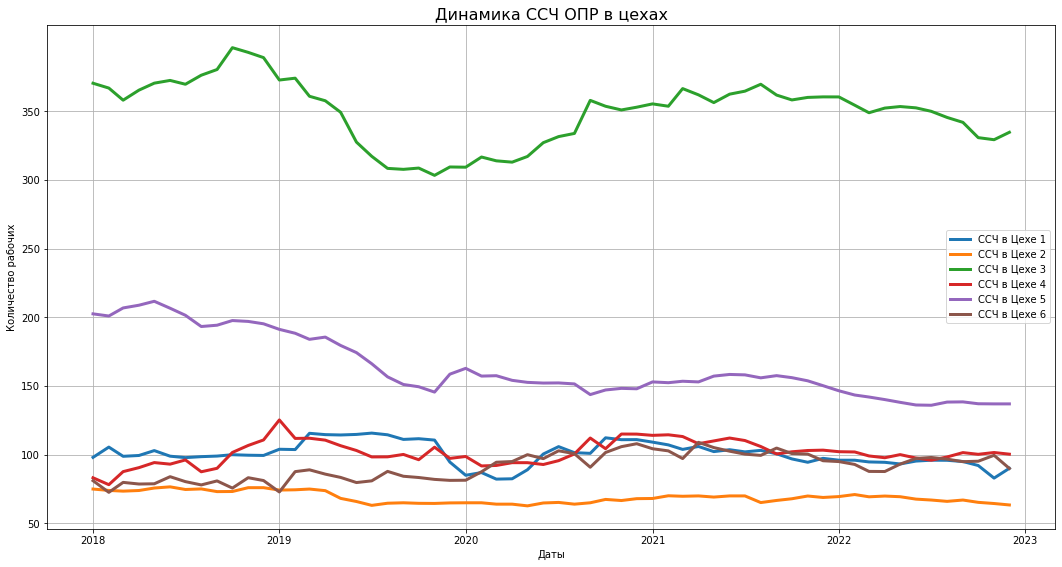

In [3]:
# Посмотрим на динамику численности по всем цехам
%matplotlib inline 
shop_1_cases = df_shop_1.groupby('Дата')['ССЧ'].sum()
shop_2_cases = df_shop_2.groupby('Дата')['ССЧ'].sum()
shop_3_cases = df_shop_3.groupby('Дата')['ССЧ'].sum()
shop_4_cases = df_shop_4.groupby('Дата')['ССЧ'].sum()
shop_5_cases = df_shop_5.groupby('Дата')['ССЧ'].sum()
shop_6_cases = df_shop_6.groupby('Дата')['ССЧ'].sum()

#визуализация графика
fig = plt.figure(figsize=(14, 7))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(shop_1_cases, label='ССЧ в Цехе 1', lw=3)
axes.plot(shop_2_cases, label='ССЧ в Цехе 2', lw=3)
axes.plot(shop_3_cases, label='ССЧ в Цехе 3', lw=3)
axes.plot(shop_4_cases, label='ССЧ в Цехе 4', lw=3)
axes.plot(shop_5_cases, label='ССЧ в Цехе 5', lw=3)
axes.plot(shop_6_cases, label='ССЧ в Цехе 6', lw=3)

#установка параметров отображения
axes.set_title('Динамика ССЧ ОПР в цехах', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Количество рабочих')
axes.set_yticks(range(50, 400, 50))
axes.grid()
axes.legend()

Для построения модели будем использовать данные по цеху 1

In [96]:
#Введем переменную для оперативного изменения источника данных
df_shop = df_shop_1
#Отложим последние пять месяцев датасета как тестовую выборку, для оценки результатов предсказания
train, test  = df_shop[:-5].copy(), df_shop[-5:].copy()
train.shape, test.shape

((55, 6), (5, 6))

##### 1. Статистические модели прогнозирования

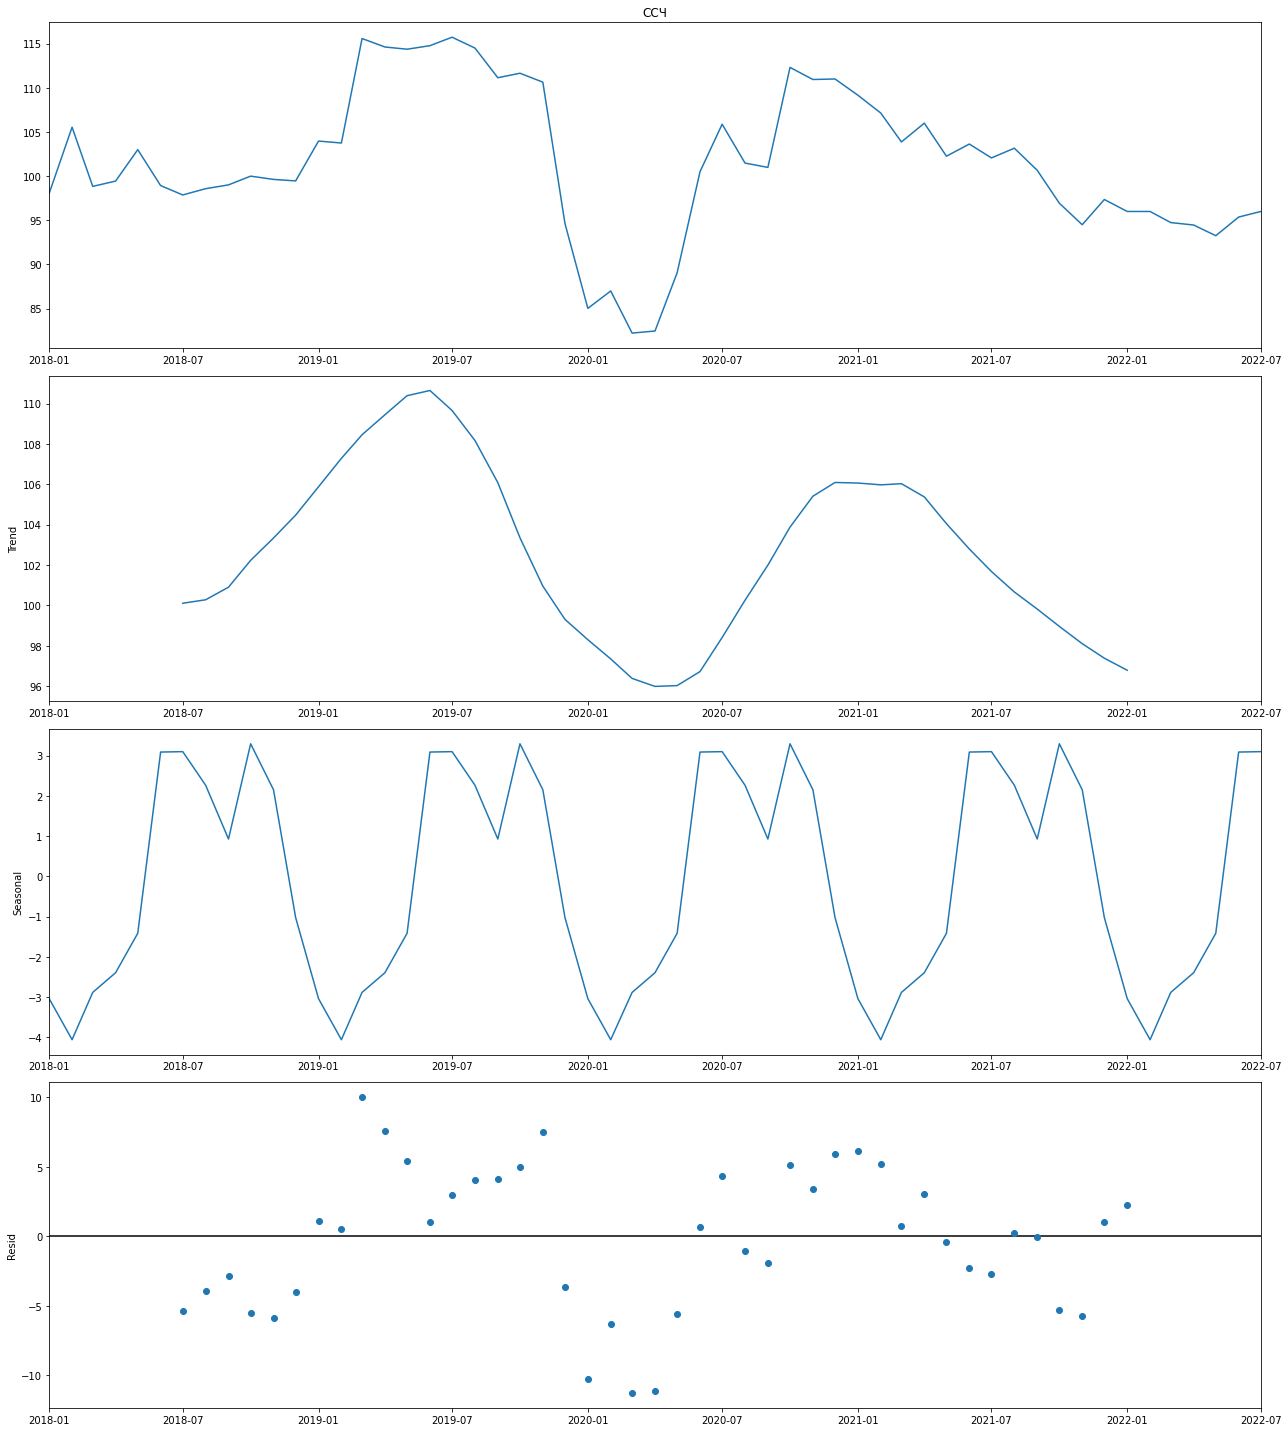

In [97]:
#Проанализируем временной ряд на наличие тренда и сезонности, выполнив сезонную декомпозицию.
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train["ССЧ"], model='additive')
result.plot()
plt.show()

Как видно из графиков, присутствует сезонность и остатки (шум).

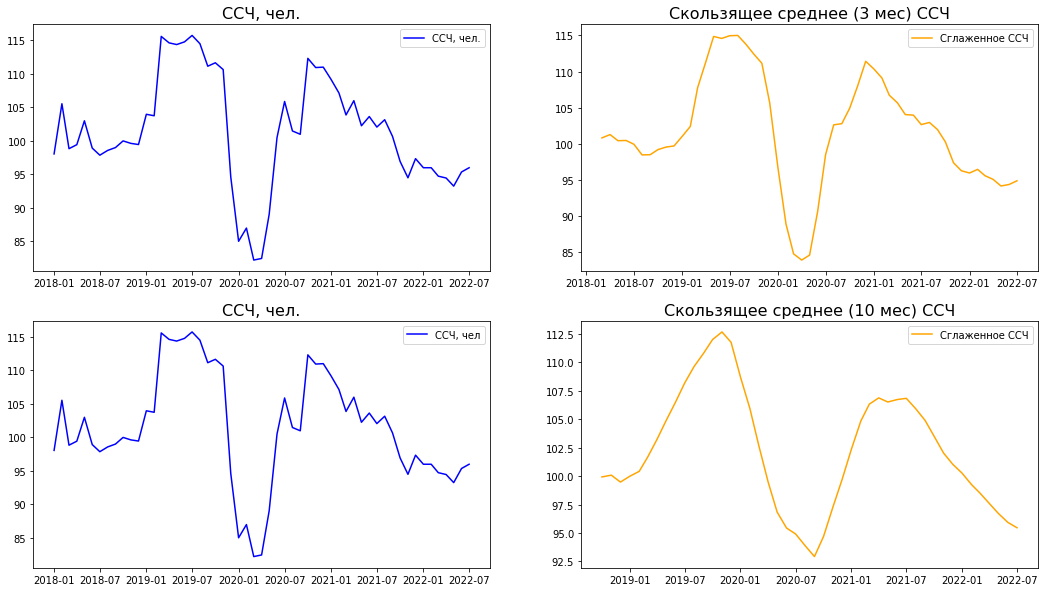

In [98]:
#Построим скользящее среднее.
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Трехмесячное (Window = 3) 
ax[0, 0].plot(train["ССЧ"], color = "blue", label = "ССЧ, чел.")
ax[0, 0].set_title("ССЧ, чел.", size = 16)
ax[0, 0].legend()

ax[0, 1].plot(train["ССЧ"].rolling(window=3).mean(), color = "orange", label = "Сглаженное ССЧ")
ax[0, 1].set_title("Скользящее среднее (3 мес) ССЧ", size = 16)
ax[0, 1].legend()


# Десятимесячное (Window = 10)
ax[1, 0].plot(train["ССЧ"], color = "blue", label = "ССЧ, чел")
ax[1, 0].set_title("ССЧ, чел.", size = 16)
ax[1, 0].legend()

ax[1, 1].plot(train["ССЧ"].rolling(window=10).mean(), color = "orange", label = "Сглаженное ССЧ")
ax[1, 1].set_title("Скользящее среднее (10 мес) ССЧ", size = 16)
ax[1, 1].legend()

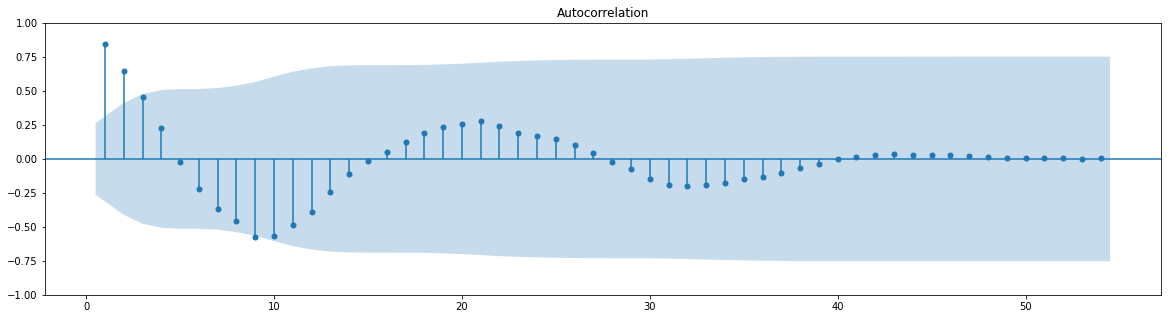

In [99]:
#Построим коррелограмму для временного ряда

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train["ССЧ"], zero = False, lags = 54)
plt.show()

Корелляция данных уменьшается со временем. Ряд имеет выраженный тренд

c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


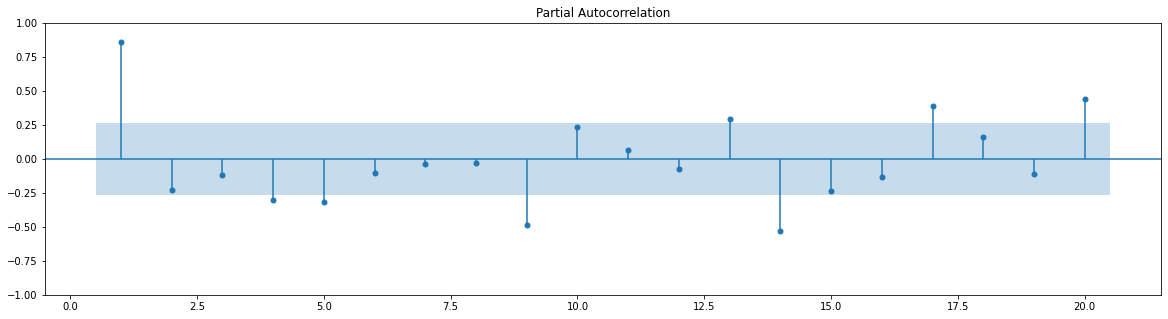

In [100]:
#Построим график частичной автокорелляции.

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train["ССЧ"], zero = False, lags = 20)
plt.show()

Данные ССЧ с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1

Тест на стационарность

In [101]:
#С помощью теста Дики-Фуллера оценим стационарность временного ряда и примиv решение о выборе модели ARMA/ARIMA
aftest = adfuller(train["ССЧ"])
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

if aftest[0]> aftest[4]['5%']: 
    print('есть единичные корни, ряд не стационарен\n')
else:
    print('единичных корней нет, ряд стационарен\n')
    
# Test for first differences
diff1 = train["ССЧ"].diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

if aftest[0]> aftest[4]['5%']: 
    print('есть единичные корни, ряд не стационарен\n')
else:
    print('единичных корней нет, ряд стационарен\n')

# Test for second differences
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

if aftest[0]> aftest[4]['5%']: 
    print('есть единичные корни, ряд не стационарен\n')
else:
    print('единичных корней нет, ряд стационарен\n')

Statistics: -2.4160865683874673
p_value: 0.13724747335621057
Critical values: {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}

есть единичные корни, ряд не стационарен

Statistics: -6.415805853402599
p_value: 1.8426044021379833e-08
Critical values: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}

единичных корней нет, ряд стационарен

Statistics: -3.9216016016973154
p_value: 0.0018814992547365092
Critical values: {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}

единичных корней нет, ряд стационарен



Временной ряд нестационарен: интегрированный ряд первого порядка. 

Применяем прогноз SARIMAX - cезонное интегрированное авторегрессионное скользящее среднее с экзогенными переменными.

Прогноз SARIMAX

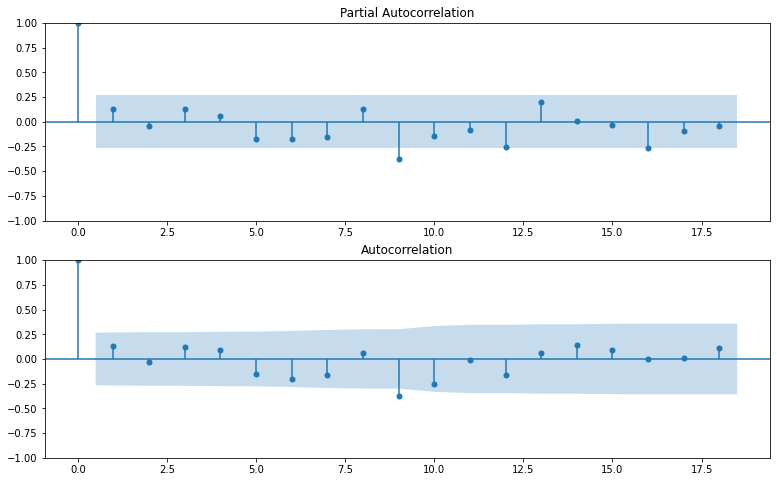

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(13,8))
sgt.plot_pacf(diff1, method='ywm', ax=ax[0])
sgt.plot_acf(diff1, ax=ax[1])
plt.show()

Параметры SARIMAX: p = 1 (по частичной автокорреляции), d = 1 (интегрированный ряд первого порядка), q = 1 (сезонность по автокорреляции), P=1 (сезонный авторегрессионный порядок, выбираем произвольный), D=1 (порядок дифференцирования сезонного ряда, выбираем произвольный), Q=1 (порядок сезонной скользящей средней, выбираем произвольный), m=6 (размер сезонного периода, по графику сезонности).

In [103]:
# Целевая функция
y = train["ССЧ"]
# Экзогенные переменные
drop_columns = ['ССЧ']
my_exog = train.drop(drop_columns, axis=1)

In [104]:
# Гиперпараметры модели
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 6)

model = SARIMAX(y, exog=my_exog, order=my_order, seasonal_order=my_seasonal_order, trend="t")
model_fit = model.fit()
model_fit.summary()

c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               ССЧ   No. Observations:                   55
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -155.172
Date:                           Tue, 09 May 2023   AIC                            332.344
Time:                                   12:54:04   BIC                            352.927
Sample:                               01-01-2018   HQIC                           340.122
                                    - 07-01-2022                                         
Covariance Type:                             opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
drift                           -0.0064      0.016     -0.393      0.695      -0.039       0.026
Загрузка план ОПР (без аут.)  4.279e-05      0.000      0.358      0.720      -0.000       0.000
Загрузка факт ОПР (без аут.)     0.0016      0.000      3.652      0.000       0.001       0.002
Коэф. выработки                  2.0294     11.379      0.178      0.858     -20.273      24.332
Коэф. невыходов                 -8.0953     11.763     -0.688      0.491     -31.151      14.960
Коэф. сверур.                  -19.4314      8.708     -2.231      0.026     -36.499      -2.364
ar.L1                           -0.9452      0.200     -4.723      0.000      -1.337      -0.553
ma.L1                          1.85e-06      0.209   8.87e-06      1.000      -0.409       0.409
ar.S.L6                         -0.2064      0.223     -0.927      0.354      -0.643       0.230
ma.S.L6                         -0.5435      0.334     -1.625      0.104      -1.199       0.112
sigma2                          30.4545      8.824      3.451      0.001      13.160      47.749
===================================================================================
Ljung-Box (L1) (Q):                   7.57   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.01   Prob(JB):                         0.88
Heteroskedasticity (H):               1.17   Skew:                            -0.01
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Побор лучших параметров с помощью pmdarima.

Параметр p: в диапазоне [1-6]. Параметр q: в диапазоне [1-2]. Оставляем интегрированный ряд первого порядка: d=1.
Задаем отсутствие стационарности (stationarity=False), присутствие сезонности (seasonal=True).

In [105]:
opt_params = pmdarima.auto_arima(
    y,
    start_p=1, start_q=1, max_p=6, max_q=2, d=1,
    start_P=1, D=1, start_Q=1, max_P=6, max_D=1, max_Q=6, max_order=10, m=6,
    stationarity=False, seasonal=True,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=329.291, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=318.538, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=327.505, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=309.831, Time=0.08 sec
 ARIMA(1,1,0)(3,1,0)[6]             : AIC=307.467, Time=0.14 sec
 ARIMA(1,1,0)(4,1,0)[6]             : AIC=309.105, Time=0.21 sec
 ARIMA(1,1,0)(3,1,1)[6]             : AIC=308.689, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=306.689, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,2)[6]             : AIC=308.689, Time=0.24 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(3,1,2)[6]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=305.380, Time=0.11 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 6)   Log Likelihood                -148.690
Date:                             Tue, 09 May 2023   AIC                            305.380
Time:                                     12:54:09   BIC                            312.865
Sample:                                 01-01-2018   HQIC                           308.209
                                      - 07-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.2940      0.265     -1.107      0.268      -0.814       0.226
ar.S.L12      -0.2366      0.234     -1.013      0.311      -0.694       0.221
ma.S.L6       -0.7298      0.500     -1.460      0.144      -1.709       0.250
sigma2        23.7676      7.514      3.163      0.002       9.040      38.495
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 7.03
Prob(Q):                              0.41   Prob(JB):                         0.03
Heteroskedasticity (H):               0.51   Skew:                             0.61
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Автоподбор параметров показал, что наилучший результат по критерию Акаике (AIC) дает моделm с гиперпараметрами: p = 0 (по частичной автокорреляции), d = 1 (интегрированный ряд первого порядка), q = 0 (сезонность по автокорреляции), P=2 (сезонный авторегрессионный порядок, выбираем произвольный), D=1 (порядок дифференцирования сезонного ряда, выбираем произвольный), Q=1 (порядок сезонной скользящей средней, выбираем произвольный), m=6 (размер сезонного периода, по графику сезонности).

In [106]:
# Гиперпараметры модели
my_order = (0, 1, 0)
my_seasonal_order = (2, 1, 1, 6)

model = SARIMAX(y, exog=my_exog, order=my_order, seasonal_order=my_seasonal_order, trend="t")
model_fit = model.fit()
model_fit.summary()

c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Penzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 ССЧ   No. Observations:                   55
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 6)   Log Likelihood                -144.395
Date:                             Tue, 09 May 2023   AIC                            308.791
Time:                                     12:54:10   BIC                            327.503
Sample:                                 01-01-2018   HQIC                           315.862
                                      - 07-01-2022                                         
Covariance Type:                               opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
drift                           -0.0106      0.035     -0.307      0.759      -0.078       0.057
Загрузка план ОПР (без аут.)  8.806e-05      0.000      0.299      0.765      -0.000       0.001
Загрузка факт ОПР (без аут.)     0.0012      0.001      2.196      0.028       0.000       0.002
Коэф. выработки                  2.0293     12.983      0.156      0.876     -23.416      27.475
Коэф. невыходов                 -8.0954     23.613     -0.343      0.732     -54.376      38.186
Коэф. сверур.                  -19.4313     13.727     -1.416      0.157     -46.336       7.474
ar.S.L6                         -0.4875      0.731     -0.667      0.505      -1.921       0.946
ar.S.L12                        -0.2969      0.543     -0.547      0.585      -1.361       0.768
ma.S.L6                         -0.2402      0.871     -0.276      0.783      -1.947       1.467
sigma2                          32.0112     13.028      2.457      0.014       6.477      57.546
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.41   Prob(JB):                         0.62
Heteroskedasticity (H):               0.48   Skew:                             0.19
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
# Предсказание
test_exog = test.drop(drop_columns, axis=1)
pred_df = pd.DataFrame(index = df_shop.index)
pred_df["model_preds"] = model_fit.predict(start = test.index[0], end = test.index[-1], exog = test_exog)
pred_df["ССЧ"] = df_shop["ССЧ"]
# Доверительный интервал
forecast = model_fit.get_forecast(test.shape[0], exog = test_exog)
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test.index, "model_preds_lower"] = forecast_df["lower ССЧ"]
pred_df.at[test.index, "model_preds_upper"] = forecast_df["upper ССЧ"]

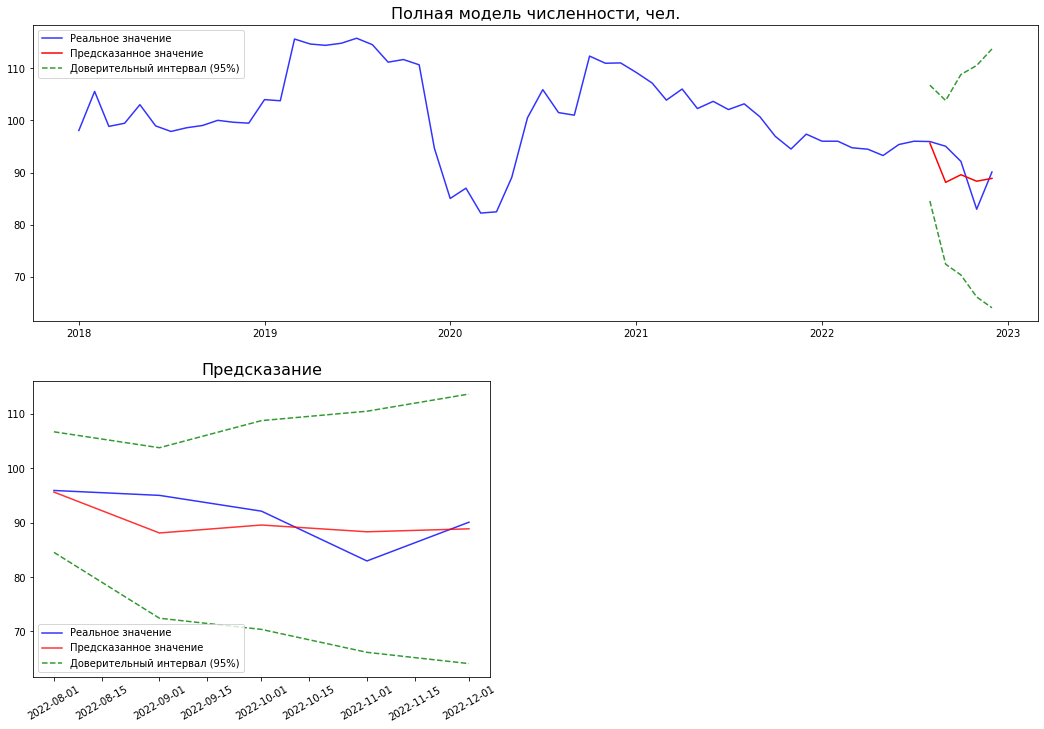

In [108]:
# Визуализируем
plt.rcParams["figure.figsize"] = 18, 12

ax1 = plt.subplot(2, 1, 1)
plt.plot(pred_df["ССЧ"], color = "blue", label = "Реальное значение", alpha = 0.8)
plt.plot(pred_df.loc[test.index]["model_preds"], color = "red", linestyle = "-", label = "Предсказанное значение")
plt.plot(pred_df.loc[test.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Доверительный интервал (95%)", alpha = 0.8)
plt.plot(pred_df.loc[test.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.8)
plt.title("Полная модель численности, чел.", size = 16)
plt.legend()

ax2 = plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test.index]["ССЧ"], color = "blue", label = "Реальное значение", alpha = 0.8)
plt.plot(pred_df.loc[test.index]["model_preds"], color = "red", linestyle = "-", label = "Предсказанное значение", alpha = 0.8)
plt.plot(pred_df.loc[test.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Доверительный интервал (95%)", alpha = 0.8)
plt.plot(pred_df.loc[test.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.8)
plt.title("Предсказание", size = 16)
ax2.xaxis.set_tick_params(rotation=30)
plt.legend()
plt.show()

##### Вывод
Прогноз построен по модели SARIMAX (cезонной интегрированной авторегрессионной скользящей средней с экзогенными переменными). Ошибки предсказания не превышают 10%. Заметно, что модель в целом ориентировалась на тренд 2019-2020 гг. и хорошо описывает его продолжение. Фактические значения не выходят за пределы 95%-го доверительного интервала.

##### 2. Гетероскедастичность

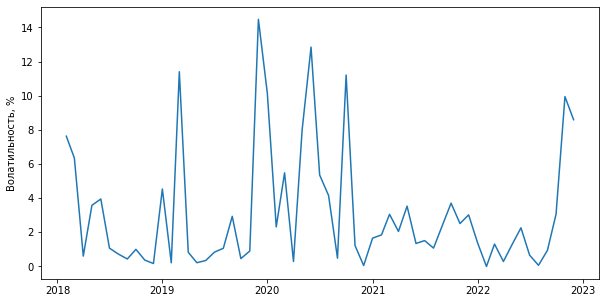

In [109]:
#Изменим волатильность ряда
volat = (df_shop.pct_change().abs() * 100)[1:]

plt.figure(figsize=(10, 5))
plt.plot(volat['ССЧ'])
plt.ylabel('Волатильность, %')
plt.show()

In [110]:
train, test = volat[:-5], volat[-5:]

# Проведем тест Dickey-Fuller
aftest = adfuller(train["ССЧ"])
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

if aftest[0]> aftest[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

Statistics: -6.027199489378027
p_value: 1.4464282507306523e-07
Critical values: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}

единичных корней нет, ряд стационарен


Ряд стационарен

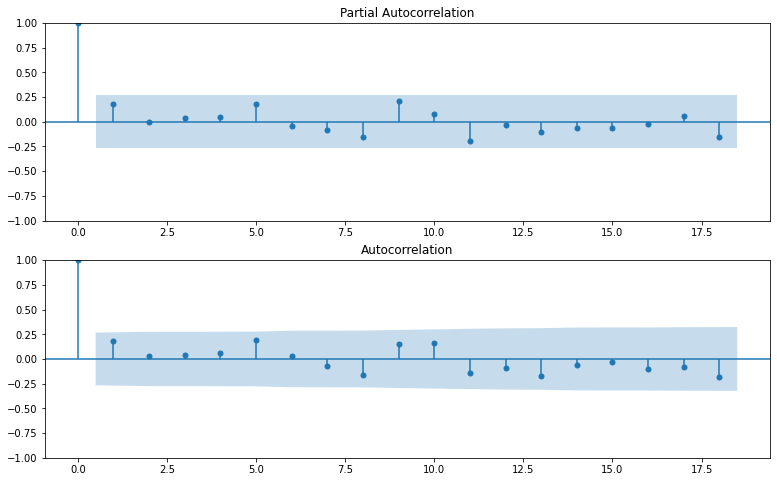

In [111]:
# Parameter selection
fig, ax = plt.subplots(2, 1, figsize=(13,8))
sgt.plot_pacf(train["ССЧ"], method='ywm', ax=ax[0])
sgt.plot_acf(train["ССЧ"], ax=ax[1])
plt.show()

Автокорреляция отсутствует, выбираем минимальные параметры GARCH: p = 1, q = 1

In [112]:
model = arch_model(volat["ССЧ"], vol='GARCH', p=1, q=1)
model_results = model.fit(last_obs=train.index[-1], update_freq=5)

garch_pred = model_results.forecast(reindex=False).variance.loc[test.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 138.33878891949576
Iteration:     10,   Func. Count:     51,   Neg. LLF: 138.20831154847957
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138.20831153051023
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


In [113]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    ССЧ   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -138.208
Distribution:                  Normal   AIC:                           284.417
Method:            Maximum Likelihood   BIC:                           292.298
                                        No. Observations:                   53
Date:                Tue, May 09 2023   Df Residuals:                       52
Time:                        12:54:11   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             3.0544      0.783      3.901  9.569e-05 [  1.520,  4.589]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.9413     25.129      0.157      0.875 [-45.310, 53.192]
alpha[1]       1.0000      3.677      0.272      0.786 [ -6.206,  8.206]
beta[1]    1.4873e-13      0.469  3.168e-13      1.000 [ -0.920,  0.920]
========================================================================

Covariance estimator: robust
"""

In [114]:
#Строим модель линейной регрессии
X_train = np.array(range(train.shape[0])).reshape(-1, 1)
y_train = train.values[:, 0]
X_test = np.array(range(
    train.shape[0], train.shape[0] + test.shape[0])).reshape(-1, 1)
y_test = test.values[:, 0]

regr = LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)
regr_pred = pd.Series(regr_pred, index=test.index)

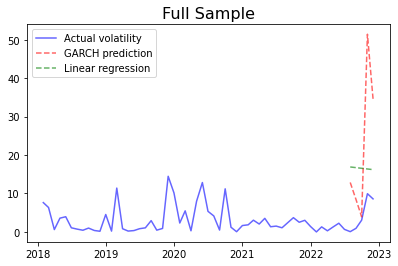

In [115]:
#Сравниваем результаты
plt.figure(figsize=(6.5, 4))
plt.plot(volat["ССЧ"], color='blue', label='Actual volatility', alpha=0.6)
plt.plot(garch_pred, color='red', linestyle='--', 
         label='GARCH prediction', alpha=0.6)
plt.plot(regr_pred, color='green', linestyle='--', 
         label='Linear regression', alpha=0.6)
plt.title('Full Sample', size=16)
plt.legend()
plt.show()

Вывод

Модель GARCH показывает значительное расхождение с фактическими значениями волатильности. Из автокорреляционных функций видно, что автокорреляция для волатильности в представленном ряде отсутствует, т.е., вообще говоря, модель GARCH в данном случае неприменима, т.к. предыдущие значения ряда не влияют/слабо влияют на последующие. Возможно, что такая зависимость смогла бы проявиться, если бы ряд был более длинным. Простая линейная регрессия показала в данном случае так же неправдоподобный прогноз.

Таким образом, для целей предсказания изменения численности ОПР, наиболлее подходит модель SARIMAX.